### Important note regarding the use of this notebook! We assume the following files are located in the same folder as this notebook: tested.molecules.csv and untested-molecules-3.csv

### Make sure the following libraries are correctly installed: pandas, rdkit, numpy, sklearn, matplotlib, xgboost, networkx


Check versions of libraries used

In [4]:
import pandas as pd
import rdkit
import numpy as np
import sklearn
import matplotlib
import xgboost as xgb
import networkx

print("pandas version:", pd.__version__)
print("rdkit version:", rdkit.__version__)
print("numpy version:", np.__version__)
print("scikit-learn version:", sklearn.__version__)
print("matplotlib version:", matplotlib.__version__)
print("xgboost version:", xgb.__version__)
print("networkx version:", networkx.__version__)

pandas version: 2.1.4
rdkit version: 2023.09.6
numpy version: 1.26.4
scikit-learn version: 1.4.2
matplotlib version: 3.8.4
xgboost version: 2.0.3
networkx version: 3.2.1


Define functions to read data and add molecular descriptors and fingerprints

In [5]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, MACCSkeys, RDKFingerprint
import numpy as np

def read_inhibition_data(csv_file_path):
    """
    Reads a CSV file with columns 'SMILES', 'PKM2_inhibition', and 'ERK2_inhibition'.

    Parameters:
        csv_file_path (str): The path to the CSV file.

    Returns:
        pd.DataFrame: A DataFrame containing the data from the CSV file.
    """
    try:
        df = pd.read_csv(csv_file_path, usecols=['SMILES', 'PKM2_inhibition', 'ERK2_inhibition'])
        return df
    except FileNotFoundError:
        print(f"The file {csv_file_path} was not found.")
        return None
    except ValueError as e:
        print(f"Error reading the CSV file: {e}")
        return None

def calculate_descriptors(mol):
    """
    Calculates molecular descriptors for a given RDKit molecule.

    Parameters:
        mol (rdkit.Chem.Mol): An RDKit molecule object.

    Returns:
        dict: A dictionary of descriptor names and their calculated values.
    """
    descriptors = {}
    for name, function in Descriptors.descList:
        try:
            descriptors[name] = function(mol)
        except:
            descriptors[name] = None
    return descriptors

def calculate_fingerprints(mol):
    """
    Calculates molecular fingerprints for a given RDKit molecule.

    Parameters:
        mol (rdkit.Chem.Mol): An RDKit molecule object.

    Returns:
        dict: A dictionary of fingerprint names and their values.
    """
    fingerprints = {}

    # Morgan Fingerprints
    morgan_fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
    fingerprints.update({f'Morgan_{i}': bit for i, bit in enumerate(morgan_fp)})

    # RDKit Fingerprints
    rdkit_fp = RDKFingerprint(mol)
    fingerprints.update({f'RDKit_{i}': bit for i, bit in enumerate(rdkit_fp)})

    # MACCS Keys
    maccs_fp = MACCSkeys.GenMACCSKeys(mol)
    fingerprints.update({f'MACCS_{i}': bit for i, bit in enumerate(maccs_fp)})

    return fingerprints

def generate_3d_conformers(mol):
    """
    Generates 3D conformers for a given RDKit molecule.

    Parameters:
        mol (rdkit.Chem.Mol): An RDKit molecule object.

    Returns:
        mol: An RDKit molecule with 3D coordinates or None if the conformers could not be generated.
    """
    mol = Chem.AddHs(mol)
    if AllChem.EmbedMolecule(mol, randomSeed=42) != 0:
        return None
    if AllChem.UFFOptimizeMolecule(mol) != 0:
        return None
    return mol

def calculate_3d_descriptors(mol):
    """
    Calculates 3D descriptors for a given RDKit molecule.

    Parameters:
        mol (rdkit.Chem.Mol): An RDKit molecule object with 3D coordinates.

    Returns:
        dict: A dictionary of 3D descriptor names and their calculated values.
    """
    descriptors = {}
    for name, function in Descriptors3D.descList:
        try:
            descriptors[name] = function(mol)
        except:
            descriptors[name] = np.nan
    return descriptors

def add_all_descriptors_to_df(df, add_fingerprints=True, add_2d_discriptors=True):
    """
    Adds all molecular descriptors and fingerprints to the DataFrame.

    Parameters:
        df (pd.DataFrame): The original DataFrame containing the 'SMILES' column.

    Returns:
        pd.DataFrame: A new DataFrame with the original columns and the calculated descriptors and fingerprints.
    """
    all_data = []
    for smiles in df['SMILES']:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            all_data.append({**{name: np.nan for name, _ in Descriptors.descList},
                             **{name: np.nan for name in range(2048)},  # Morgan Fingerprints
                             **{name: np.nan for name in range(2048)},  # RDKit Fingerprints
                             **{name: np.nan for name in range(166)},   # MACCS Keys
                             **{name: np.nan for name, _ in Descriptors3D.descList}})
            continue
        if add_2d_discriptors:
            # 2D Descriptors
            descriptors_2d = calculate_descriptors(mol)

        if add_fingerprints:
            # Fingerprints
            fingerprints = calculate_fingerprints(mol)

        # # 3D Descriptors
        # mol_3d = generate_3d_conformers(mol)
        # if mol_3d:
        #     descriptors_3d = calculate_3d_descriptors(mol_3d)
        # else:
        #     descriptors_3d = {name: np.nan for name, _ in Descriptors3D.descList}
        if add_fingerprints and add_2d_discriptors:
            all_data.append({**descriptors_2d, **fingerprints})
            
        elif add_2d_discriptors:
            all_data.append({**descriptors_2d})
        elif add_fingerprints:
            all_data.append({**fingerprints})
    
    descriptors_df = pd.DataFrame(all_data)
    result_df = pd.concat([df.reset_index(drop=True), descriptors_df.reset_index(drop=True)], axis=1)
    return result_df


Create a balanced train and test split of the dataset with the known inhibitions to take into consideration relatively small amount of inhibitors within dataset.

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

csv_path = 'tested_molecules.csv'

df = pd.read_csv(csv_path)

print('Unsplit dataset')
print(df.shape, df['PKM2_inhibition'].sum(), df['ERK2_inhibition'].sum())

# Define the features and targets
X = df.drop(columns=['PKM2_inhibition', 'ERK2_inhibition'])
y_PKM2 = df['PKM2_inhibition']
y_ERK2 = df['ERK2_inhibition']

# Identify the row where both PKM2_inhibition and ERK2_inhibition are positive
rare_instance = df[(df['PKM2_inhibition'] == 1) & (df['ERK2_inhibition'] == 1)]

# Remove the rare instance from the dataset
df_remaining = df.drop(rare_instance.index)

# Define the features and combined target for the remaining data
X_remaining = df_remaining.drop(columns=['PKM2_inhibition', 'ERK2_inhibition'])
y_combined_remaining = df_remaining['PKM2_inhibition'].astype(str) + df_remaining['ERK2_inhibition'].astype(str)

# Perform the train-test split using the remaining data
X_train, X_test, y_train_combined, y_test_combined = train_test_split(
    X_remaining, y_combined_remaining, test_size=0.1, random_state=42, stratify=y_combined_remaining
)

# Separate the combined target back into individual targets for training and testing
y_train_PKM2 = y_train_combined.apply(lambda x: int(x[0]))
y_train_ERK2 = y_train_combined.apply(lambda x: int(x[1]))
y_test_PKM2 = y_test_combined.apply(lambda x: int(x[0]))
y_test_ERK2 = y_test_combined.apply(lambda x: int(x[1]))


# Convert combined training data back to DataFrame
X_train['PKM2_inhibition'] = y_train_PKM2.values
X_train['ERK2_inhibition'] = y_train_ERK2.values

# Add the rare instance back to the training set
X_train = pd.concat([X_train, rare_instance])

# Convert combined test data back to DataFrame
X_test['PKM2_inhibition'] = y_test_PKM2.values
X_test['ERK2_inhibition'] = y_test_ERK2.values

# Reset indices to avoid any indexing issues
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

# Now you have the training and test DataFrames
train_df = X_train
test_df = X_test

# Optionally, verify the contents of the DataFrames
print("Training DataFrame:")
print(train_df.shape, train_df['PKM2_inhibition'].sum(), train_df['ERK2_inhibition'].sum())
print("\nTest DataFrame:")
print(test_df.shape,test_df['PKM2_inhibition'].sum(), test_df['ERK2_inhibition'].sum())

Unsplit dataset
(1116, 3) 28 51
Training DataFrame:
(1004, 3) 25 46

Test DataFrame:
(112, 3) 3 5


Calculate all molecular descriptors in the module Descriptors, with default options

In [7]:
train_df_descriptors = add_all_descriptors_to_df(train_df, add_2d_discriptors=True, add_fingerprints=False)
train_df_fingerprints = add_all_descriptors_to_df(train_df, add_2d_discriptors=False, add_fingerprints=True)

test_df_descriptors = add_all_descriptors_to_df(test_df, add_2d_discriptors=True, add_fingerprints=False)
test_df_fingerprints = add_all_descriptors_to_df(test_df, add_2d_discriptors=False, add_fingerprints=True)

Perform the variable exclusion.

In [8]:
import matplotlib.pyplot as plt
import networkx as nx
import tkinter as tk
# Functions
def find_significant_correlations(corr_matrix, high_threshold=0.8, low_threshold=-0.8):
    """
    Find pairs of indices with very high positive/negative or zero correlation coefficients.
    Function writen by chatGPT 4o

    Parameters:
    corr_matrix (pd.DataFrame): Correlation matrix of size n x n
    high_threshold (float): Threshold for very high positive correlation
    low_threshold (float): Threshold for very high negative correlation

    Returns:
    dict: Dictionary with keys 'positive', 'negative', and 'zero' containing pairs of indices
    """
    positive_pairs = []
    negative_pairs = []
    zero_pairs = []

    # Iterate over the upper triangle of the matrix (excluding the diagonal)
    for i in range(corr_matrix.shape[0]):
        for j in range(i + 1, corr_matrix.shape[1]):
            coefficient = corr_matrix.iat[i, j]
            if coefficient >= high_threshold:
                positive_pairs.append((corr_matrix.index[i], corr_matrix.columns[j]))
            elif coefficient <= low_threshold:
                negative_pairs.append((corr_matrix.index[i], corr_matrix.columns[j]))
            elif coefficient == 0:
                zero_pairs.append((corr_matrix.index[i], corr_matrix.columns[j]))
    
    return {
        'positive': positive_pairs,
        'negative': negative_pairs,
        'zero': zero_pairs
    }

def select_variable_to_keep_with_gui(subgraph):
    """
    Display a pop-up window with a list of variables to keep and exclude, and allow the user to select
    one variable to keep and provide a note for the selection.

    Parameters:
    subgraph (set): A set of variable names in the subgraph

    Returns:
    dict: Dictionary with keys 'keep', 'exclude', and 'note' containing the selected variables and the note
    """
    root = tk.Tk()
    root.title("Select Variable to Keep")

    frame = tk.Frame(root)
    frame.pack(padx=10, pady=10)

    label = tk.Label(frame, text="Select the variable to keep from the subgraph:")
    label.pack()

    variables = list(subgraph)
    keep_var = tk.StringVar()
    keep_var.set(variables[0])  # Default to the first variable

    for var in variables:
        rb = tk.Radiobutton(frame, text=var, variable=keep_var, value=var)
        rb.pack(anchor='w')

    note_label = tk.Label(frame, text="Add a note for the selection:")
    note_label.pack()
    note_text = tk.Text(frame, height=4, width=40)
    note_text.pack()

    def on_submit():
        selected_keep_var = keep_var.get()
        exclude_vars = [var for var in variables if var != selected_keep_var]
        note = note_text.get("1.0", tk.END).strip()
        result['keep'] = selected_keep_var
        result['exclude'] = exclude_vars
        result['note'] = note
        root.destroy()

    submit_btn = tk.Button(frame, text="Submit", command=on_submit)
    submit_btn.pack(pady=10)

    result = {}
    root.mainloop()

    return result


def identify_redundant_variables(significant_pairs, plot=False):
    """
    Identify redundant variables based on correlation and user selection.

    Parameters:
    corr_matrix (pd.DataFrame): Correlation matrix of size n x n
    significant_pairs (dict): Dictionary with keys 'positive', 'negative', and 'zero' containing pairs of indices

    Returns:
    set: Set of variables to exclude
    """
    # Create a graph
    G = nx.Graph()

    # Add edges for positive and negative correlations
    for correlation_type in ['positive', 'negative']:
        for (i, j) in significant_pairs[correlation_type]:
            G.add_edge(i, j)

    # Find connected components (subgraphs)
    subgraphs = list(nx.connected_components(G))

    if plot:
        # Compute node sizes based on degree (number of connections)
        degrees = dict(G.degree())
        node_sizes = [degrees[node] * 100 for node in G.nodes()]
        # Draw the graph with increased spacing
        plt.figure(figsize=(12, 12))
        pos = nx.spring_layout(G, iterations=50)  # Increase k for more spacing
        nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='skyblue', alpha=0.7)
        nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.1)
        nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

        plt.title('Significant Correlation Pairs Graph')
        plt.show()

    # Identify variables to exclude from each subgraph
    variables_to_exclude = set()
    for subgraph in subgraphs:
        selection = select_variable_to_keep_with_gui(subgraph)
        variables_to_exclude.update(selection['exclude'])

        # Print the node, included and excluded variables, and the note to the terminal
        print(f"Subgraph: {sorted(subgraph)}")
        print(f"Included Variable: {selection['keep']}")
        print(f"Excluded Variables: {selection['exclude']}")
        print(f"Note: {selection['note']}")

    return variables_to_exclude


In [9]:
# variance_threshold = 10.0
# correlation_threshold = 0.9

# # Find and select highly correlated function
# df_2d_discriptors = pd.concat([train_df_descriptors, test_df_descriptors])
# correlation = df_2d_discriptors.corr(numeric_only=True)
# pairs = find_significant_correlations(correlation, high_threshold=correlation_threshold, low_threshold=-correlation_threshold)
# variables_to_exclude = identify_redundant_variables(pairs, plot=True)

# # Find low variance variables
# variance = df_2d_discriptors.var(numeric_only=True)
# mean = df_2d_discriptors.mean(numeric_only=True)
# variance_mean_df = pd.DataFrame({'Descriptor': variance.index, 'Mean': mean.values, 'Variance': variance.values})

# # Calculate the percentage that the variance is of the mean   
# variance_mean_df['Percentage variance of mean'] = abs(variance_mean_df['Variance'] / variance_mean_df['Mean']) * 100
# variance_mean_df.sort_values(by='Percentage variance of mean', ascending=True, inplace=True)

# # Determine the low variable discriptors based on threshold
# low_variance_descriptors = variance_mean_df[variance_mean_df['Percentage variance of mean'] < variance_threshold]['Descriptor'].tolist()

# # Combine the lists of variables to exclude and exclude them
# all_variables_to_exclude = set(variables_to_exclude).union(low_variance_descriptors)

In [10]:
# The variables we determined to be excluded, DO NOT RUN if you want to use your own variable exclusion
all_variables_to_exclude = ['Chi0n', 'FpDensityMorgan1', 'BCUT2D_LOGPHI', 'fr_benzene', 'fr_phenol_noOrthoHbond', 'fr_Al_OH_noTert', 'Chi4v', 'BCUT2D_CHGHI', 
                      'FpDensityMorgan2', 'NHOHCount', 'Chi0v', 'LabuteASA', 'MaxPartialCharge', 'BCUT2D_MWLOW', 'SlogP_VSA6', 'MaxAbsEStateIndex', 
                      'MinPartialCharge', 'Chi0', 'BalabanJ', 'HeavyAtomCount', 'Chi1v', 'MolMR', 'FractionCSP3', 'fr_Nhpyrrole', 'MaxAbsPartialCharge', 
                      'BCUT2D_LOGPLOW', 'HeavyAtomMolWt', 'fr_ketone_Topliss', 'Chi2n', 'Chi3v', 'Chi1', 'BCUT2D_CHGLO', 'qed', 'Kappa2', 'Kappa1', 
                      'fr_COO2', 'fr_C_O_noCOO', 'Chi3n', 'MinAbsPartialCharge', 'Chi1n', 'Chi2v', 'fr_nitro_arom', 'NumValenceElectrons', 'AvgIpc', 
                      'ExactMolWt', 'Chi4n', 'FpDensityMorgan3', 'SMR_VSA2']

Exclude variables from the dataframes

In [11]:
train_df_descriptors.drop(all_variables_to_exclude, axis=1, inplace=True)
test_df_descriptors.drop(all_variables_to_exclude, axis=1, inplace=True)

Create pkl files of balanced  descriptors and fingerprint dataframes.

In [12]:
train_path_descriptors = "train_descriptors.pkl"
train_path_fingerprints = "train_fingerprints.pkl"

train_df_descriptors.to_pickle(train_path_descriptors)
train_df_fingerprints.to_pickle(train_path_fingerprints)


test_path_descriptors = "test_descriptors.pkl"
test_path_fingerprints = "test_fingerprints.pkl"
test_df_descriptors.to_pickle(test_path_descriptors)
test_df_fingerprints.to_pickle(test_path_fingerprints)

Do the same for the untested molecules.

In [13]:
mol = pd.read_csv(r'untested_molecules-3.csv') 

mol_fingerprints = add_all_descriptors_to_df(mol, add_2d_discriptors=False, add_fingerprints=True)
mol_descriptors = add_all_descriptors_to_df(mol, add_2d_discriptors=True, add_fingerprints=False)

print(mol_descriptors.head())

mol_descriptors.drop(all_variables_to_exclude, axis=1, inplace=True)

print(mol_descriptors.head())

untested_path_descriptors = 'untested_descriptors.pkl'
untested_path_fingerprints = 'untested_fingerprints.pkl'
mol_descriptors.to_pickle(untested_path_descriptors)
mol_fingerprints.to_pickle(untested_path_fingerprints)

                                       SMILES  PKM2_inhibition  \
0  C[C@@H](Sc1nc(=O)cc(N)[nH]1)C(=O)NC1CCCCC1              NaN   
1          O=C(CCN1C(=O)COc2ccccc21)NCc1cccs1              NaN   
2      Cn1nnnc1SCC(=O)N1CC[NH+](Cc2ccccc2)CC1              NaN   
3  CCOC(=O)CCP(=O)([O-])[C@@H](O)c1ccc(OC)cc1              NaN   
4               C=CCNC(=O)c1cc(-c2ccccc2O)on1              NaN   

   ERK2_inhibition  MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  \
0              NaN          12.102478       12.102478           0.021321   
1              NaN          11.985063       11.985063           0.021654   
2              NaN          12.287562       12.287562           0.163668   
3              NaN          11.932898       11.932898           0.197446   
4              NaN          11.589256       11.589256           0.075648   

   MinEStateIndex       qed        SPS    MolWt  ...  fr_sulfide  \
0       -0.399409  0.573774  17.650000  296.396  ...           1   
1       -0

Perform PCA on the training dataset and use these values to transform the test set and untested molecules. We only apply this on the non-binary data, so we leave the fingerprints out of the PCA.

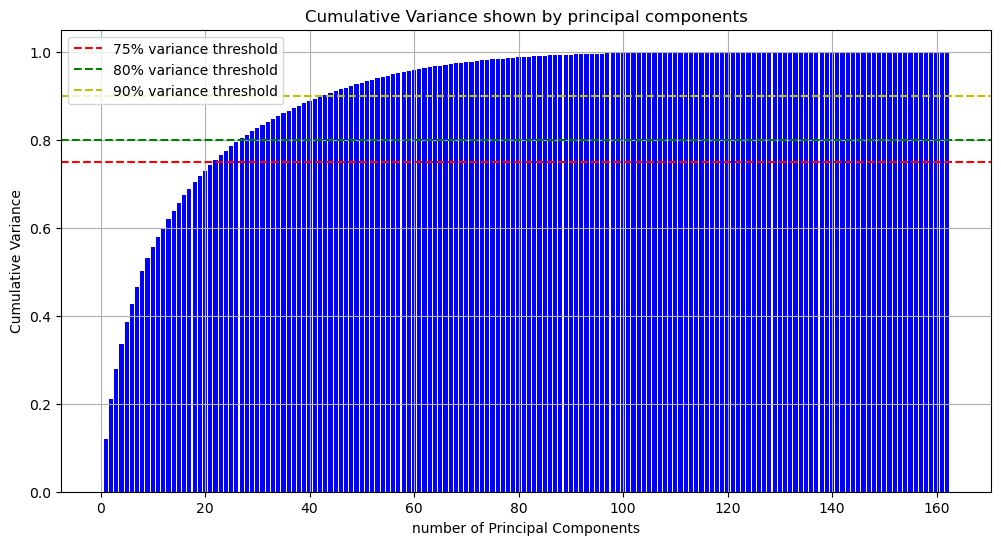

Number of PCs to capture 80% variance: 27


In [14]:
# Loading of packages
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Reading in of data
df_train_old = pd.read_pickle(train_path_descriptors)
df_train = df_train_old.reset_index()

df_test_old = pd.read_pickle(test_path_descriptors)
df_test = df_test_old.reset_index()

df_untested_old = pd.read_pickle(untested_path_descriptors)
df_untested = df_untested_old.reset_index()

# Compute dataframes that only contain features
df_train_features_only = df_train.drop(columns=['index', 'PKM2_inhibition', 'ERK2_inhibition', 'SMILES'])
df_test_features_only = df_test.drop(columns=['index', 'PKM2_inhibition', 'ERK2_inhibition', 'SMILES'])
df_untested_features_only = df_untested.drop(columns=['index', 'SMILES', 'PKM2_inhibition', 'ERK2_inhibition'])

# Scale the data
scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(df_train_features_only)
test_scaled = scaler.fit_transform(df_test_features_only)
untested_scaled = scaler.fit_transform(df_untested_features_only)

# Perform PCA
pca = PCA()
pca_features = pca.fit(train_scaled)

# We calculate the cumulative variance by the summation of the variance captured per principal component
cumulative_variance = np.cumsum(pca_features.explained_variance_ratio_)

# Make a plot to see how many PCs are neccesary to capture amount of variance
plt.figure(figsize=(12, 6))
plt.bar(range(1, len(cumulative_variance) + 1), cumulative_variance, color='blue')
plt.axhline(y=0.75, color='r', linestyle='--', label='75% variance threshold')
plt.axhline(y=0.80, color='g', linestyle='--', label='80% variance threshold')
plt.axhline(y=0.90, color='y', linestyle='--', label='90% variance threshold')
plt.xlabel('number of Principal Components')
plt.ylabel('Cumulative Variance')
plt.title('Cumulative Variance shown by principal components')
plt.legend(loc='best')
plt.grid(True)
plt.show()

num_components_80_variance = np.argmax(cumulative_variance >= 0.80) + 1 #returns indices, so we do +1 for the nr of principal components
print('Number of PCs to capture 80% variance:', num_components_80_variance)
pca_columns_80 = [f'PC{i+1}' for i in range(num_components_80_variance)]
pca_80 = PCA(n_components=num_components_80_variance)

# Transform data accordingly
pca_train_transformed = pca_80.fit_transform(train_scaled)
pca_test_transformed = pca_80.fit_transform(test_scaled)
pca_untested_transformed = pca_80.fit_transform(untested_scaled)

# Format back into dataframes
train_transformed_df = pd.DataFrame(pca_train_transformed, columns=pca_columns_80)
test_transformed_df = pd.DataFrame(pca_test_transformed, columns=pca_columns_80)
untested_transformed_df = pd.DataFrame(pca_untested_transformed, columns=pca_columns_80)

df_train_information = df_train[['SMILES', 'PKM2_inhibition', 'ERK2_inhibition']]
df_test_information = df_test[['SMILES', 'PKM2_inhibition', 'ERK2_inhibition']]
df_untested_information = df_untested[['SMILES']]

# Combine the columns describing the molecule and their inhibition with the PC values
complete_train_df = pd.concat([df_train_information, train_transformed_df], axis=1)
complete_test_df = pd.concat([df_test_information, test_transformed_df], axis=1)
complete_untested_df = pd.concat([df_untested_information, untested_transformed_df], axis=1)

# Add two empty columns to the untested df
complete_untested_df['PKM2_inhibition'] = pd.NA
complete_untested_df['ERK2_inhibition'] = pd.NA

# Save the dfs as pkl files
complete_train_df.to_pickle('complete_train_pca.pkl')
complete_test_df.to_pickle('complete_test_pca.pkl')
complete_untested_df.to_pickle('complete_untested.pkl')


Perform prediction on test set

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Model balanced accuracy score after hyperparameter tuning: 0.4845
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Model balanced accuracy score after hyperparameter tuning: 0.4949
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Model balanced accuracy score after hyperparameter tuning: 0.5000
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Model balanced accuracy score after hyperparameter tuning: 0.6148
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Model balanced accuracy score after hyperparameter tuning: 0.5000
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Model balanced accuracy score after hyperparameter tuning: 0.4974
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Model balanced accuracy score after hyperparameter tuning: 0.5000
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Model balanced accuracy score after hyperparameter

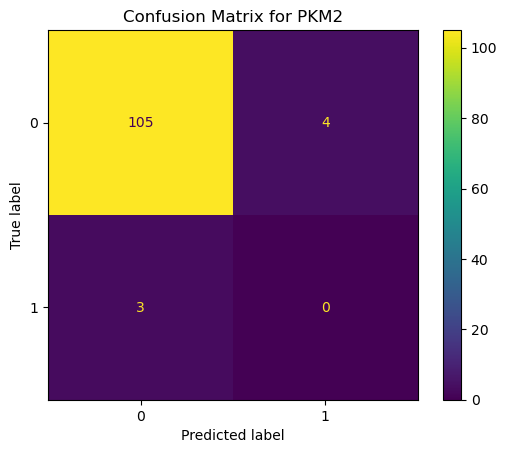

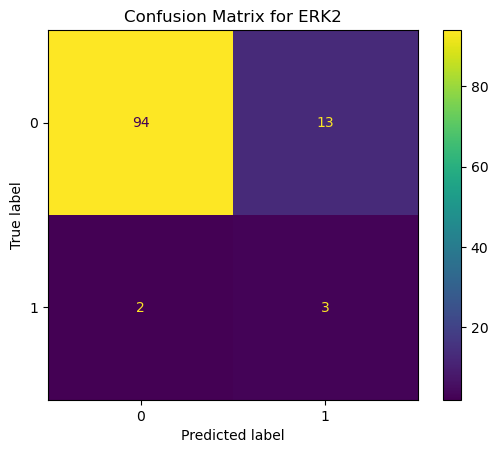

Balanced Accuracy for PKM2: 0.4817
Balanced Accuracy for ERK2: 0.7393


In [15]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import balanced_accuracy_score, ConfusionMatrixDisplay, confusion_matrix
import xgboost as xgb
from sklearn.utils.class_weight import compute_sample_weight

## ---------------- Read file do dataframe
def read_data(input_file):
    """
    Reads the input file and returns a dataframe.

    Parameters
    ----------
    input_file : str
        Name of the input file in string format
    
    Returns
    -------
    data : dataframe
        Dataframe of the information in input file
    """
    data = pd.read_pickle(input_file)
    return data


## ---------------- Using random search to optimize random forest
def find_hyperparameters(X_train, X_test, y_train, y_test):
    """
    Returns the parameters for the random forest classifier that result in 
    the highest balanced accuracy score.

    Parameters
    ----------
    X_train : dataframe
        Dataframe containing the feature values used for training the model
    X_test : dataframe
        Dataframe containing the feature values used for testing the model
    y_train : dataframe
        Dataframe containing the output variables used to train the model
    y_test : dataframe
        Dataframe containing the output variables to be predicted

    Returns
    -------
    best_model : RandomForestClassifier
        Random forest classifier that results in the best balanced
        accuracy score
    best_params : dict
        Dictionary containing the values of the hyperparameters that result
        in the best balanced accuracy score
    bal_acc_score : float
        Balanced accuracy score of the value to be predicted
    """
    # Hyperparameter grid
    param_grid = {
        'n_estimators': list(range(1, 21)),                                     # Amount of trees to use
        'max_depth': [None] + list(np.linspace(3, 100, num=100).astype(int)),  # Maximum number of levels in tree
        'max_features': ['sqrt', 'log2', None] + list(np.arange(0.1, 1.1, 0.1)),# Number of features to consider at every split
        'max_leaf_nodes': [None] + list(np.linspace(10, 100, num=100).astype(int)),# How many leaf nodes can be visited
        'min_samples_split': [2, 5, 10, 15],                                    # Minimum number of samples required to split a node
        'bootstrap': [True, False]                                              # Method of selecting samples for training each tree
    }

    # Estimator for use in random search
    rfc = RandomForestClassifier(random_state=42)

    # Create the random search model
    rs = RandomizedSearchCV(rfc, param_grid, n_jobs=-1, 
                            scoring='balanced_accuracy', cv=3, 
                            n_iter=10, verbose=1, random_state=42)

    # Fit 
    rs.fit(X_train, y_train)
    best_model = rs.best_estimator_
    best_params = rs.best_params_
    prediction = best_model.predict(X_test)
    
    # Calculate the balanced accuracy score for each target
    bal_acc_score = balanced_accuracy_score(y_test, prediction)
    print('Model balanced accuracy score after hyperparameter tuning: {0:0.4f}'.format(
        bal_acc_score)
    )
    return best_model, best_params, bal_acc_score


## ---------------- Find five models by use of cross validation
def find_models(inhibition, train_data_file):
    """
    Performs cross-validation on the train dataset,
    returns five different models

    Parameters
    ----------
    inhibition : str
        The name of the variable (kinase) to be predicted
    train_data_file : str
        The name of the file that contains the data
    
    Returns
    -------
    models_CV : list of dict
        List containing a dict per model created using the random
        forest classifier
    """
    data = read_data(train_data_file)
    # Features
    X = data.drop(columns=['PKM2_inhibition', 'SMILES', 'ERK2_inhibition'], axis=1)
    
    # Values to be predicted
    y = data[inhibition]

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    models_CV = []
    
    i = 1
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        best_model, best_params, bal_acc_score = find_hyperparameters(X_train, X_test, y_train, y_test)
        models_CV.append(best_model)
        
        i += 1
        
    return models_CV

def models_svm(model, inhibition, train_data_file):
    data = read_data(train_data_file)
    # Features
    X = data.drop(columns=['PKM2_inhibition', 'SMILES', 'ERK2_inhibition'], axis=1)
    # Values to be predicted
    y = data[inhibition]
    model.fit(X, y)
    return model

def models_xgboost(model, inhibition, train_data_file):
    data = read_data(train_data_file)
    # Features
    X = data.drop(columns=['PKM2_inhibition', 'SMILES', 'ERK2_inhibition'], axis=1)
    
    # Values to be predicted
    y = data[inhibition]
    
    # Compute class weights
    class_weights = compute_sample_weight(class_weight='balanced', y=y)
    model.fit(X, y, sample_weight=class_weights)
    return model

## ---------------- Confusion Matrix
# Print the Confusion Matrix and slice it into four pieces
def create_confusion_matrix(y_test, y_pred, title):
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(title)
    plt.show()

def average_predictionRF(models_CV):
    cv_predictions = []
    for i, rfc_model in enumerate(models_CV, start=1):
        y_pred = rfc_model['y_pred']
        cv_predictions.append(y_pred)

    # Stack the predictions and average them
    rf_cv_preds_stacked = np.column_stack(cv_predictions)
    rf_avg_preds = np.mean(rf_cv_preds_stacked, axis=1)

    # Convert averaged predictions to binary (0 or 1) based on the 0.4 threshold
    rf_final_preds = (rf_avg_preds >= 0.4).astype(int)
    return rf_final_preds

def predict_model_training(models_CV, X_test, y_test):  # used during training when you have the y_test
    Models_pred = []
    for fitted_model in models_CV:
        y_pred = fitted_model.predict(X_test)
        bal_acc_score = balanced_accuracy_score(y_test, y_pred)
        Models_pred.append({'Model 1': fitted_model,
                            'y_test': y_test, 'y_pred': y_pred, 'BAcc': bal_acc_score})
    return Models_pred

def predict_model(models_CV, X_test):
    Models_pred = []
    for fitted_model in models_CV:
        y_pred = fitted_model.predict(X_test)
        Models_pred.append({'Model 1': fitted_model,
                            'y_pred': y_pred})
    return Models_pred

## ---------------- Call the functions to create the models
# Insert paths to files where input_file contains all the testing and
# training data, train_data_file only contains the training data and
# test_data_file only contains the data used for testing.

train_data_file = 'complete_train_pca.pkl'
train_data_file_bin = 'train_fingerprints.pkl'
test_data_file = 'complete_test_pca.pkl'
test_data_file_bin = 'test_fingerprints.pkl'

#______________TRAIN descriptor models______________
# Non-binary descriptor models
#_______RANDOM FOREST______
# PKM2 Models
models_CV_PKM2 = find_models('PKM2_inhibition', train_data_file)
# ERK2 Models
models_CV_ERK2 = find_models('ERK2_inhibition', train_data_file)


#_______SVM_______
# PKM2 Models
svm_PKM2 = SVC(class_weight='balanced', probability=True, gamma=0.5, C=1)
models_SVM_PKM2 = models_svm(svm_PKM2, 'PKM2_inhibition', train_data_file)
# ERK2 Models
svm_ERK2 = SVC(class_weight='balanced', probability=True, gamma=1, C=1)
models_SVM_ERK2 = models_svm(svm_ERK2, 'ERK2_inhibition', train_data_file)

#_______XGBOOST_______
# PKM2 Models
xgb_PKM2 = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')
models_xgb_PKM2 = models_xgboost(xgb_PKM2, 'PKM2_inhibition', train_data_file)
# ERK2 Models
xgb_ERK2 = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')
models_xgb_ERK2 = models_xgboost(xgb_ERK2, 'ERK2_inhibition', train_data_file)

# Binary descriptor models
#_______RANDOM FOREST______
# PKM2 Models
models_CV_PKM2_bin = find_models('PKM2_inhibition', train_data_file_bin)
# ERK2 Models
models_CV_ERK2_bin = find_models('ERK2_inhibition', train_data_file_bin)


#______________PREDICT NON-BINARY descriptor models______________
predictions_PKM2 = {}
predictions_ERK2 = {}
# Get test data
# for non-binary models
test_data = read_data(test_data_file)
X_test = test_data.drop(columns=['PKM2_inhibition', 'SMILES', 'ERK2_inhibition'], axis=1)
y_test_PKM2 = test_data['PKM2_inhibition']
y_test_ERK2 = test_data['ERK2_inhibition']

# for binary models
test_data_bin = read_data(test_data_file_bin)
X_test_bin = test_data_bin.drop(columns=['PKM2_inhibition', 'SMILES', 'ERK2_inhibition'], axis=1)
y_test_PKM2_bin = test_data_bin['PKM2_inhibition']
y_test_ERK2_bin = test_data_bin['ERK2_inhibition']

#_______RANDOM FOREST Non-binary_______
# PKM2 Models
CV_pred_PKM2 = predict_model(models_CV_PKM2, X_test)
rf_pred_pkm2 = average_predictionRF(CV_pred_PKM2)
predictions_PKM2['RandomForest'] = rf_pred_pkm2
# ERK2 Models
CV_pred_ERK2 = predict_model(models_CV_ERK2, X_test)
rf_pred_ERK2 = average_predictionRF(CV_pred_ERK2)
predictions_ERK2['RandomForest'] = rf_pred_ERK2

#_______SVM_______
# PKM2 Models
# make list of models
models_SVM_PKM2_list = [models_SVM_PKM2]
SVM_pred_PKM2 = predict_model(models_SVM_PKM2_list, X_test)
predictions_PKM2['SVM'] = SVM_pred_PKM2[0]['y_pred']
# ERK2 Models
models_SVM_ERK2_list = [models_SVM_ERK2]
SVM_pred_ERK2 = predict_model(models_SVM_ERK2_list, X_test)
predictions_ERK2['SVM'] = SVM_pred_ERK2[0]['y_pred']

#_______XGBOOST_______
# PKM2 Models
models_xgb_PKM2_list = [models_xgb_PKM2]
xgb_pred_PKM2 = predict_model(models_xgb_PKM2_list, X_test)
predictions_PKM2['xgb'] = xgb_pred_PKM2[0]['y_pred']
# ERK2 Models
models_xgb_ERK2_list = [models_xgb_ERK2]
xgb_pred_ERK2 = predict_model(models_xgb_ERK2_list, X_test)
predictions_ERK2['xgb'] = xgb_pred_ERK2[0]['y_pred']

#_______RANDOM FOREST_______
# PKM2 Models
CV_pred_PKM2_bin = predict_model(models_CV_PKM2_bin, X_test_bin)
rf_pred_pkm2_bin = average_predictionRF(CV_pred_PKM2_bin)
predictions_PKM2['RandomForest_fingerprints'] = rf_pred_pkm2_bin
# ERK2 Models
CV_pred_ERK2_bin = predict_model(models_CV_ERK2_bin, X_test_bin)
rf_pred_ERK2_bin = average_predictionRF(CV_pred_ERK2_bin)
predictions_ERK2['RandomForest_fingerprints'] = rf_pred_ERK2_bin

#______________VOTING____________
def voting_mechanism(predictions):
    # Convert dictionary values to a list of numpy arrays
    preds_list = list(predictions.values())
    # Stack predictions horizontally to get a 2D array
    stacked_preds = np.column_stack(preds_list)
    # Apply the voting rule: 1 if any model predicts 1, else 0
    final_preds = np.any(stacked_preds == 1, axis=1).astype(int)
    return final_preds

final_preds_PKM2 = voting_mechanism(predictions_PKM2)
final_preds_ERK2 = voting_mechanism(predictions_ERK2)

# Create confusion matrices for PKM2 and ERK2
create_confusion_matrix(y_test_PKM2, final_preds_PKM2, title='Confusion Matrix for PKM2')
create_confusion_matrix(y_test_ERK2, final_preds_ERK2, title='Confusion Matrix for ERK2')

# Calculate and print balanced accuracy scores
bal_acc_PKM2 = balanced_accuracy_score(y_test_PKM2, final_preds_PKM2)
bal_acc_ERK2 = balanced_accuracy_score(y_test_ERK2, final_preds_ERK2)
print(f'Balanced Accuracy for PKM2: {bal_acc_PKM2:.4f}')
print(f'Balanced Accuracy for ERK2: {bal_acc_ERK2:.4f}')

201 201 201 201


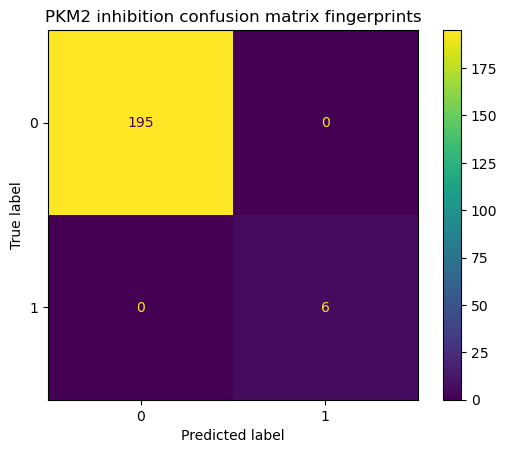

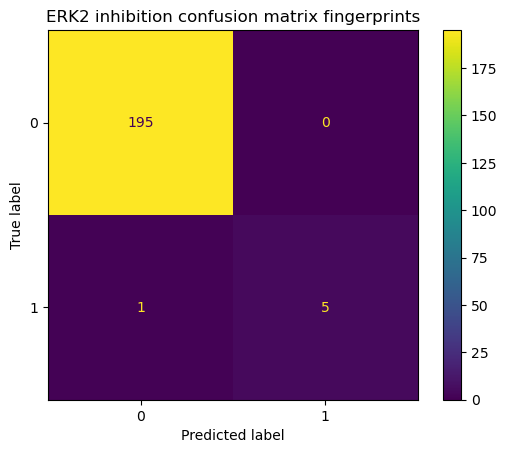

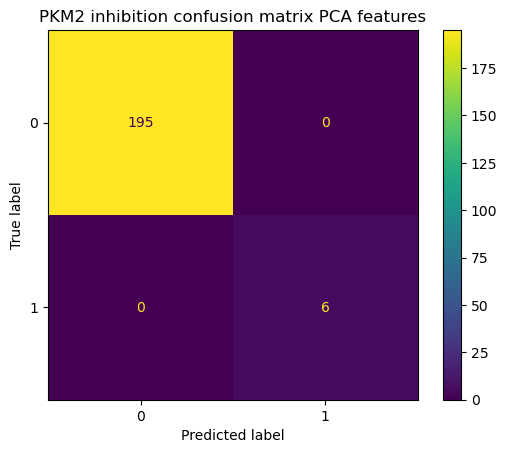

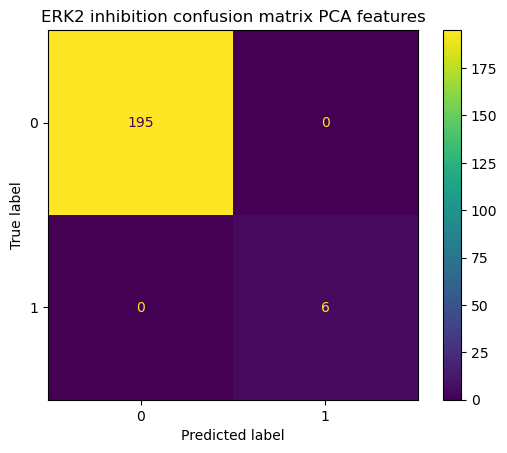

In [22]:
## Create confusion matrices for the RF models
data_bin = read_data(train_data_file_bin)
data = read_data(train_data_file)

# ___________ Non-Binary
X = data.drop(columns=['PKM2_inhibition','SMILES', 'ERK2_inhibition'], axis=1)
y_PKM2 = data['PKM2_inhibition']
_, X_test, _, y_test_PKM2 = train_test_split(X, y_PKM2, test_size=0.2, random_state=10)
y_ERK2 = data['ERK2_inhibition']
_, X_test, _, y_test_ERK2 = train_test_split(X, y_ERK2, test_size=0.2, random_state=10)
# PKM2 Models
CV_pred_PKM2=predict_model(models_CV_PKM2, X_test)   
rf_pred_pkm2=average_predictionRF(CV_pred_PKM2)
# ERK2 Models
CV_pred_ERK2=predict_model(models_CV_ERK2, X_test)   
rf_pred_ERK2=average_predictionRF(CV_pred_ERK2)

# ___________ Binary
X_bin = data_bin.drop(columns=['PKM2_inhibition','SMILES', 'ERK2_inhibition'], axis=1)
y_PKM2_bin = data_bin['PKM2_inhibition']
_, X_test_bin, _, y_test_bin_PKM2 = train_test_split(X_bin, y_PKM2_bin, test_size=0.2, random_state=10)
y_ERK2_bin = data_bin['ERK2_inhibition']
_, X_test_bin, _, y_test_bin_ERK2 = train_test_split(X_bin, y_ERK2_bin, test_size=0.2, random_state=10)
# PKM2 Models
CV_pred_PKM2_bin=predict_model(models_CV_PKM2_bin, X_test_bin)   
rf_pred_pkm2_bin=average_predictionRF(CV_pred_PKM2_bin)
# ERK2 Models
CV_pred_ERK2_bin=predict_model(models_CV_ERK2_bin, X_test_bin)   
rf_pred_ERK2_bin=average_predictionRF(CV_pred_ERK2_bin)

create_confusion_matrix(y_test_bin_PKM2, rf_pred_pkm2_bin.tolist(), title='PKM2 inhibition confusion matrix fingerprints')
create_confusion_matrix(y_test_bin_ERK2, rf_pred_ERK2_bin.tolist(), title='ERK2 inhibition confusion matrix fingerprints')

create_confusion_matrix(y_test_PKM2, rf_pred_pkm2.tolist(), title='PKM2 inhibition confusion matrix PCA features')
create_confusion_matrix(y_test_ERK2, rf_pred_ERK2.tolist(), title='ERK2 inhibition confusion matrix PCA features')


Perform prediction on untested molecules and format output accordingly.

In [33]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, KFold, train_test_split
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
from sklearn.utils.class_weight import compute_sample_weight

# Function to read data from a file
def read_data(input_file):
    data = pd.read_pickle(input_file)
    return data

# Function to find hyperparameters for RandomForestClassifier
def find_hyperparameters(X_train, X_test, y_train, y_test):
    param_grid = {
        'n_estimators': list(range(1, 21)),
        'max_depth': [None] + list(np.linspace(3, 100, num=100).astype(int)),
        'max_features': ['sqrt', 'log2', None] + list(np.arange(0.1, 1.1, 0.1)),
        'max_leaf_nodes': [None] + list(np.linspace(10, 100, num=100).astype(int)),
        'min_samples_split': [2, 5, 10, 15],
        'bootstrap': [True, False]
    }
    rfc = RandomForestClassifier(random_state=42)
    rs = RandomizedSearchCV(rfc, param_grid, n_jobs=4, scoring='balanced_accuracy', cv=3, n_iter=10, verbose=1, random_state=42)
    rs.fit(X_train, y_train)
    best_model = rs.best_estimator_
    best_params = rs.best_params_
    prediction = best_model.predict(X_test)
    bal_acc_score = balanced_accuracy_score(y_test, prediction)
    print(f'Model balanced accuracy score after hyperparameter tuning: {bal_acc_score:.4f}')
    return best_model, best_params, bal_acc_score

# Function to find models using cross-validation
def find_models(inhibition, train_data_file):
    data = read_data(train_data_file)
    X = data.drop(columns=['PKM2_inhibition', 'SMILES', 'ERK2_inhibition'], axis=1)
    y = data[inhibition]
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    models_CV = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        best_model, best_params, bal_acc_score = find_hyperparameters(X_train, X_test, y_train, y_test)
        models_CV.append(best_model)
    return models_CV

# Function to train SVM model
def models_svm(model, inhibition, train_data_file):
    data = read_data(train_data_file)
    X = data.drop(columns=['PKM2_inhibition', 'SMILES', 'ERK2_inhibition'], axis=1)
    y = data[inhibition]
    model.fit(X, y)
    return model

# Function to train XGBoost model
def models_xgboost(model, inhibition, train_data_file):
    data = read_data(train_data_file)
    X = data.drop(columns=['PKM2_inhibition', 'SMILES', 'ERK2_inhibition'], axis=1)
    y = data[inhibition]
    class_weights = compute_sample_weight(class_weight='balanced', y=y)
    model.fit(X, y, sample_weight=class_weights)
    return model

# Function to average predictions from RandomForest models
def average_predictionRF(models_CV, X_test):
    cv_predictions = []
    for model in models_CV:
        y_pred = model.predict(X_test)
        cv_predictions.append(y_pred)
    rf_cv_preds_stacked = np.column_stack(cv_predictions)
    rf_avg_preds = np.mean(rf_cv_preds_stacked, axis=1)
    rf_final_preds = (rf_avg_preds >= 0.4).astype(int)
    return rf_final_preds

# Function to predict with models
def predict_model(models_CV, X_test):
    y_preds = []
    for model in models_CV:
        y_pred = model.predict(X_test)
        y_preds.append(y_pred)
    return y_preds

# Function to apply voting mechanism on predictions
def voting_mechanism(predictions):
    preds_list = list(predictions.values())
    stacked_preds = np.column_stack(preds_list)
    final_preds = np.any(stacked_preds == 1, axis=1).astype(int)
    return final_preds

# Load train data files
train_data_file = 'complete_train_pca.pkl'
train_data_file_bin = 'train_fingerprints.pkl'

# Train RandomForest models
models_CV_PKM2 = find_models('PKM2_inhibition', train_data_file)
models_CV_ERK2 = find_models('ERK2_inhibition', train_data_file)
models_CV_PKM2_bin = find_models('PKM2_inhibition', train_data_file_bin)
models_CV_ERK2_bin = find_models('ERK2_inhibition', train_data_file_bin)

# Train SVM models
svm_PKM2 = SVC(class_weight='balanced', probability=True, gamma=0.5, C=1)
models_SVM_PKM2 = models_svm(svm_PKM2, 'PKM2_inhibition', train_data_file)
svm_ERK2 = SVC(class_weight='balanced', probability=True, gamma=1, C=1)
models_SVM_ERK2 = models_svm(svm_ERK2, 'ERK2_inhibition', train_data_file)

# Train XGBoost models
xgb_PKM2 = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')
models_xgb_PKM2 = models_xgboost(xgb_PKM2, 'PKM2_inhibition', train_data_file)
xgb_ERK2 = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')
models_xgb_ERK2 = models_xgboost(xgb_ERK2, 'ERK2_inhibition', train_data_file)

# Read untested data files
untested_fingerprints = 'untested_fingerprints.pkl'
untested_pca = 'complete_untested.pkl'
test_data_file_bin = untested_fingerprints
test_data_file = untested_pca

# Read test data
test_data = read_data(test_data_file)
X_test = test_data.drop(columns=['PKM2_inhibition', 'SMILES', 'ERK2_inhibition'], axis=1)

test_data_bin = read_data(test_data_file_bin)
X_test_bin = test_data_bin.drop(columns=['PKM2_inhibition', 'SMILES', 'ERK2_inhibition'], axis=1)

# Predict with RandomForest models and store predictions in a dictionary
predictions_PKM2 = {}
predictions_PKM2['RandomForest'] = average_predictionRF(models_CV_PKM2, X_test)
predictions_PKM2['RandomForest_fingerprints'] = average_predictionRF(models_CV_PKM2_bin, X_test_bin)

predictions_ERK2 = {}
predictions_ERK2['RandomForest'] = average_predictionRF(models_CV_ERK2, X_test)
predictions_ERK2['RandomForest_fingerprints'] = average_predictionRF(models_CV_ERK2_bin, X_test_bin)

# Predict with SVM models and store predictions in the dictionary
predictions_PKM2['SVM'] = models_SVM_PKM2.predict(X_test)
predictions_ERK2['SVM'] = models_SVM_ERK2.predict(X_test)

# Predict with XGBoost models and store predictions in the dictionary
predictions_PKM2['XGBoost'] = models_xgb_PKM2.predict(X_test)
predictions_ERK2['XGBoost'] = models_xgb_ERK2.predict(X_test)

# Apply voting mechanism to get final predictions
final_preds_PKM2 = voting_mechanism(predictions_PKM2)
final_preds_ERK2 = voting_mechanism(predictions_ERK2)

# Load the untested molecules CSV file
untested_molecules_file = 'untested_molecules-3.csv'
untested_molecules = pd.read_csv(untested_molecules_file)

# Update the NaN values in PKM2_inhibition and ERK2_inhibition columns with the predictions
untested_molecules.loc[untested_molecules['PKM2_inhibition'].isna(), 'PKM2_inhibition'] = final_preds_PKM2
untested_molecules.loc[untested_molecules['ERK2_inhibition'].isna(), 'ERK2_inhibition'] = final_preds_ERK2

# Convert the values to integers
untested_molecules['PKM2_inhibition'] = untested_molecules['PKM2_inhibition'].astype(int)
untested_molecules['ERK2_inhibition'] = untested_molecules['ERK2_inhibition'].astype(int)

# Save the updated CSV file
output_file = 'untested_molecules-3_updated.csv'
untested_molecules.to_csv(output_file, index=False)

print(f'Updated file saved to {output_file}')

# Count and print the number of molecules with PKM2 inhibition and ERK2 inhibition
pkm2_inhibition_count = untested_molecules['PKM2_inhibition'].sum()
erk2_inhibition_count = untested_molecules['ERK2_inhibition'].sum()

print(f'Number of molecules with PKM2 inhibition: {pkm2_inhibition_count}')
print(f'Number of molecules with ERK2 inhibition: {erk2_inhibition_count}')



Fitting 3 folds for each of 10 candidates, totalling 30 fits
Model balanced accuracy score after hyperparameter tuning: 0.5547
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Model balanced accuracy score after hyperparameter tuning: 0.5000
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Model balanced accuracy score after hyperparameter tuning: 0.5000
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Model balanced accuracy score after hyperparameter tuning: 0.6199
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Model balanced accuracy score after hyperparameter tuning: 0.5000
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Model balanced accuracy score after hyperparameter tuning: 0.5000
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Model balanced accuracy score after hyperparameter tuning: 0.5395
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Model balanced accuracy score after hyperparameter